In [14]:
import math

def calculate_distance(rgb1, rgb2):
    r1, g1, b1 = rgb1
    r2, g2, b2 = rgb2
    return math.sqrt((r2 - r1) ** 2 + (g2 - g1) ** 2 + (b2 - b1) ** 2)

d={}
def find_closest_rgb(rgb, rgb_values=rgb_2000):
    if rgb in d:
        return d[rgb]
    closest_rgb = None
    closest_distance = float('inf')
    for rgb_value in rgb_values:
        distance = calculate_distance(rgb, rgb_value[:3])
        if distance < closest_distance:
            closest_distance = distance
            closest_rgb = rgb_value
    d[rgb]=closest_rgb
    return closest_rgb

In [2]:
from PIL import Image
import csv
# Read the RGB and temperature values from the first CSV file
with open('./scale/scale_2000.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row if it exists
    rgb_2000 = [list(map(int, row[:4])) for row in reader]
with open('./scale/scale_2010.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row if it exists
    rgb_2010 = [list(map(int, row[:4])) for row in reader]
with open('./scale/scale_2020.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row if it exists
    rgb_2020 = [list(map(int, row[:4])) for row in reader]

scales=[rgb_2000,rgb_2010,rgb_2020]


In [6]:


# Load the temperature color map image
image1 = Image.open("../../Data/Images/new/l_1993.bmp")
image2 = Image.open("../../Data/Images/new/l_2003.bmp")
image3 = Image.open("../../Data/Images/new/l_2013.bmp")
image4= Image.open("../../Data/Images/new/l_2023.bmp")

# Resize image2 and image3 to match the resolution of image1
image2 = image2.resize(image1.size)
image3 = image3.resize(image1.size)
image4 = image4.resize(image1.size)

images = [image1, image2, image3, image4]

csv_path1= "../../Data/csv/new/1993_og.csv"
csv_path2= "../../Data/csv/new/2003_og.csv"
csv_path3= "../../Data/csv/new/2013_og.csv"
csv_path4= "../../Data/csv/new/2023_og.csv"
csv_paths = [csv_path1, csv_path2, csv_path3, csv_path4]

In [15]:
for image, csv_path in zip(images,csv_paths):
    # Create a CSV file to store the temperature data
    
    csv_file = open(csv_path, "w", newline="")
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["X", "Y", "r", "g", "b", "Temperature"])
    
    # Iterate over each pixel in the image and extract temperature data
    pixels = image.load()
    width, height = image.size

    for x in range(width):
        for y in range(height):
            r, g, b = pixels[x, y]
            closest_rgb = find_closest_rgb((r,g,b))
            csv_writer.writerow([x, y] + closest_rgb)
    # Close the CSV file
    csv_file.close()

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

In [17]:
# Read the CSV files
df_1993 = pd.read_csv('../../Data/csv/new/1993_og.csv')
df_2003 = pd.read_csv('../../Data/csv/new/2003_og.csv')
df_2013 = pd.read_csv('../../Data/csv/new/2013_og.csv')
df_2023 = pd.read_csv('../../Data/csv/new/2023_og.csv')

# Extract the third column as input and output
data_1993 = df_1993.iloc[:, 5].values
data_2003 = df_2003.iloc[:, 5].values
data_2013 = df_2013.iloc[:, 5].values
data_2023 = df_2023.iloc[:, 5].values
for_predict = df_2023.iloc[:, 5].values
input_d = np.concatenate((data_1993, data_2003, data_2013))
output_d = np.concatenate((data_2003, data_2013, data_2023))

In [18]:
# Preprocess the data
# (Perform any necessary preprocessing steps such as scaling or normalization here)
from sklearn.preprocessing import MinMaxScaler

# Reshape the input data to have two dimensions
data_2000_reshaped = np.reshape(input_d, (-1, 1))
data_2010_reshaped = np.reshape(output_d, (-1, 1))

# Normalize the input data
scaler = MinMaxScaler()
data_2000_normalized = scaler.fit_transform(data_2000_reshaped)
data_2010_normalized = scaler.transform(data_2010_reshaped)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(input_d, output_d, test_size=0.2)

# Reshape the data for LSTM input (assuming 1 feature per timestep)
X_train = np.reshape(X_train, (X_train.shape[0], 1, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 1))

In [19]:
# # Define the LSTM model
# model = Sequential()
# model.add(LSTM(128, input_shape=(1, 1)))  # Adjust the number of units (128) as needed
# model.add(Dense(1))  # Output layer with 1 unit

# # Compile the model
# model.compile(loss='mean_squared_error', optimizer='adam')

# # Train the model
# model.fit(X_train, y_train, epochs=3, batch_size=32)  # Adjust batch_size and epochs as needed

# # Evaluate the model
# loss = model.evaluate(X_test, y_test)

# # Make predictions
# predictions = model.predict(X_test)
from keras.layers import Dropout
from keras.optimizers import Adam

model = Sequential()
model.add(LSTM(256, input_shape=(1, 1)))
model.add(Dropout(0.2))  # Add dropout regularization
model.add(Dense(1))

# Adjust the learning rate of the optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Train the model
model.fit(X_train, y_train, epochs=2, batch_size=30)

# Evaluate the model
loss = model.evaluate(X_test, y_test)

# Make predictions
predictions = model.predict(X_test)

Epoch 1/2
 41790/313257 [===>..........................] - ETA: 42:23 - loss: 75.2239

KeyboardInterrupt: 

RMSE: 9.670204366012392


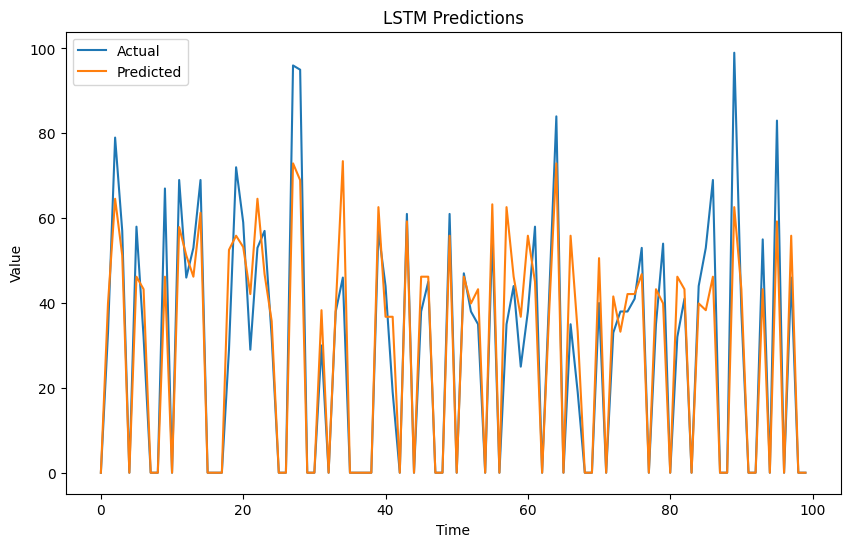

In [17]:
import matplotlib.pyplot as plt

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE:', rmse)

# Visualize the predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test[0:100], label='Actual')
plt.plot(predictions[0:100], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('LSTM Predictions')
plt.legend()
plt.show()

In [18]:
predict_input = np.reshape(data_2010, (data_2010.shape[0], 1, 1))
predictions_2020 = model.predict(predict_input)

79990/79990 [==============================] - 255s 3ms/step


In [19]:
for_predict = np.reshape(for_predict, (for_predict.shape[0], 1, 1))
predictions_2030 = model.predict(for_predict)

39995/39995 [==============================] - 134s 3ms/step


In [20]:
predictions_2020 = predictions_2020.ravel()
predictions_2030 = predictions_2030.ravel()

In [21]:
predictions_2020

array([-0.00233531, -0.00233531, -0.00233531, ..., -0.00233531,
       -0.00233531, -0.00233531], dtype=float32)

In [22]:
predict_df_2020=df_2000.copy()

In [23]:
predict_df_2030=df_2000.copy()

In [24]:
predict_df_2020.head()

,X,Y,r,g,b,Temperature
0,0,0,0,0,0,0
1,0,1,0,0,0,0
2,0,2,0,0,0,0
3,0,3,0,0,0,0
4,0,4,0,0,0,0


In [25]:
# def calculate_dist_temp(t1, t2):
#     return abs(t1-t2)

# def find_closest_temp(temp):
#     closest_rgb = None
#     closest_distance = float('inf')
#     for rgb_value in rgb_temperature_values:
#         distance = calculate_dist_temp(temp, rgb_value[3])
#         if distance < closest_distance:
#             closest_distance = distance
#             closest_rgb = rgb_value
#     return closest_rgb

In [29]:
temp_dict = {}

# Iterate over the predictions and update the DataFrame
for index, temp in enumerate(predictions_2020):
    # if temp in temp_dict:
    #     closest_rgb = temp_dict[temp]
    # else:
    closest_rgb = None
    closest_distance = float('inf')
    for rgb_value in rgb_temperature_values:
        # distance = calculate_dist_temp(temp, rgb_value[3])
        distance = abs(rgb_value[3]-temp)
        if distance < closest_distance:
            closest_distance = distance
            closest_rgb = rgb_value
        # temp_dict[temp] = closest_rgb

    predict_df_2020.loc[index, ['r', 'g', 'b', 'Temperature']] = closest_rgb[:4]


In [ ]:
r=0
for index, temp in enumerate(predictions_2030):
    if temp in temp_dict:
        closest_rgb = temp_dict[temp]
    else:
        r+=1
        closest_rgb = None
        closest_distance = float('inf')
        for rgb_value in rgb_temperature_values:
            # distance = calculate_dist_temp(temp, rgb_value[3])
            distance = abs(rgb_value[3]-temp)
            if distance < closest_distance:
                closest_distance = distance
                closest_rgb = rgb_value
        temp_dict[temp] = closest_rgb

    predict_df_2030.loc[index, ['r', 'g', 'b', 'Temperature']] = closest_rgb[:4]

In [ ]:
# Iterate over rows in the DataFrame and modify values
# for index, row in predict_df.iterrows():
#     closest_rgb = find_closest_temp(predictions_2020[index])
#     predict_df.loc[index, ['r', 'g', 'b', 'Temperature']] = closest_rgb[:4]
del temp_dict
print(r)

0


In [ ]:
# df to csv
predict_df_2020.to_csv('predicted_2020.csv', index=False)


In [ ]:
predict_df_2030.to_csv('predicted_2030.csv', index=False)

In [ ]:
# Read the CSV file
data = pd.read_csv('predicted_2020.csv')

# Get the maximum row and column values
max_row = data['Y'].max()
max_column = data['X'].max()

# Create a blank image with the size based on the maximum row and column values
imag1 = np.zeros((max_row + 1, max_column + 1, 3), dtype=np.uint8)
bg=data.loc[0, 'Temperature']
# Iterate over the rows of the CSV data
for index, row in data.iterrows():
    r, c, red, green, blue, t = row['Y'], row['X'], row['r'], row['g'], row['b'], row['Temperature']
    if t==bg:
        red, green, blue = 0, 0, 0
    imag1[r, c] = (blue, green, red)  # Set the pixel value in the image



In [ ]:
import pandas as pd
import numpy as np

# Read the CSV file
# data = pd.read_csv('predicted_2030.csv')
data = pd.read_csv('2000_og.csv')

# Get the maximum row and column values
max_row = data['Y'].max()
max_column = data['X'].max()

# Create a blank image with the size based on the maximum row and column values
imag2 = np.zeros((max_row + 1, max_column + 1, 3), dtype=np.uint8)
bg=data.loc[0, 'Temperature']
# Iterate over the rows of the CSV data
for index, row in data.iterrows():
    r, c, red, green, blue, t = row['Y'], row['X'], row['r'], row['g'], row['b'], row['Temperature']
    if t==bg:
        red, green, blue = 0, 0, 0
    imag2[r, c] = (blue, green, red)  # Set the pixel value in the image



In [ ]:
import cv2

# Display the image
# cv2.imshow('Image', image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Save the reconstructed image
output_image_path = "output_image1.bmp"
cv2.imwrite(output_image_path, imag1)

print("Image saved successfully.")

In [ ]:
output_image_path = "output_image2.bmp"
cv2.imwrite(output_image_path, imag2)

print("Image saved successfully.")

Image saved successfully.
